In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'benchmark_lapa',
        root = '..',
        default_wildcards={'sample': 'WTC11'}
    )

In [2]:
from pathlib import Path 
import pandas as pd
import numpy as np
import pyranges as pr
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from lapa.result import LapaResult
from sklearn.metrics import precision_recall_curve, auc

In [3]:
results = dict()

for i in snakemake.input['lapa_dir']:
    library_prep, platform, _ = Path(i).name.split('_')
    results[f'{library_prep} {platform}'] = LapaResult(i, tpm_cutoff=0)

In [4]:
core_cols = ['Chromosome', 'Start', 'End', 'Strand']

In [5]:
result_quantseq = LapaResult(snakemake.input['quantseq'][0], tpm_cutoff=5)
replicated = (result_quantseq.counts() > 0).all(axis=1)

df_quantseq = LapaResult(snakemake.input['quantseq'][0], tpm_cutoff=0) \
    .read_cluster(filter_internal_priming=False).drop_duplicates(core_cols)
df_quantseq = df_quantseq.loc[replicated[replicated].index]
df_quantseq = df_quantseq[df_quantseq['signal'] != 'None@None']

gr_quantseq = pr.PyRanges(df_quantseq, int64=True)

In [6]:
def join_outer(gr1, gr2, suffix):
    return gr1.join(gr2, strandedness='same', how='outer', suffix=suffix)

In [7]:
results_benchmark = dict()

for k, result in tqdm(results.items()):  
    df = result.read_cluster().drop_duplicates(core_cols)
    df = df[df['signal'] != 'None@None']
    gr =  pr.PyRanges(df, int64=True)
    df = join_outer(gr_quantseq, gr, f'_{k}').df

    results_benchmark[k] = df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.39s/it]


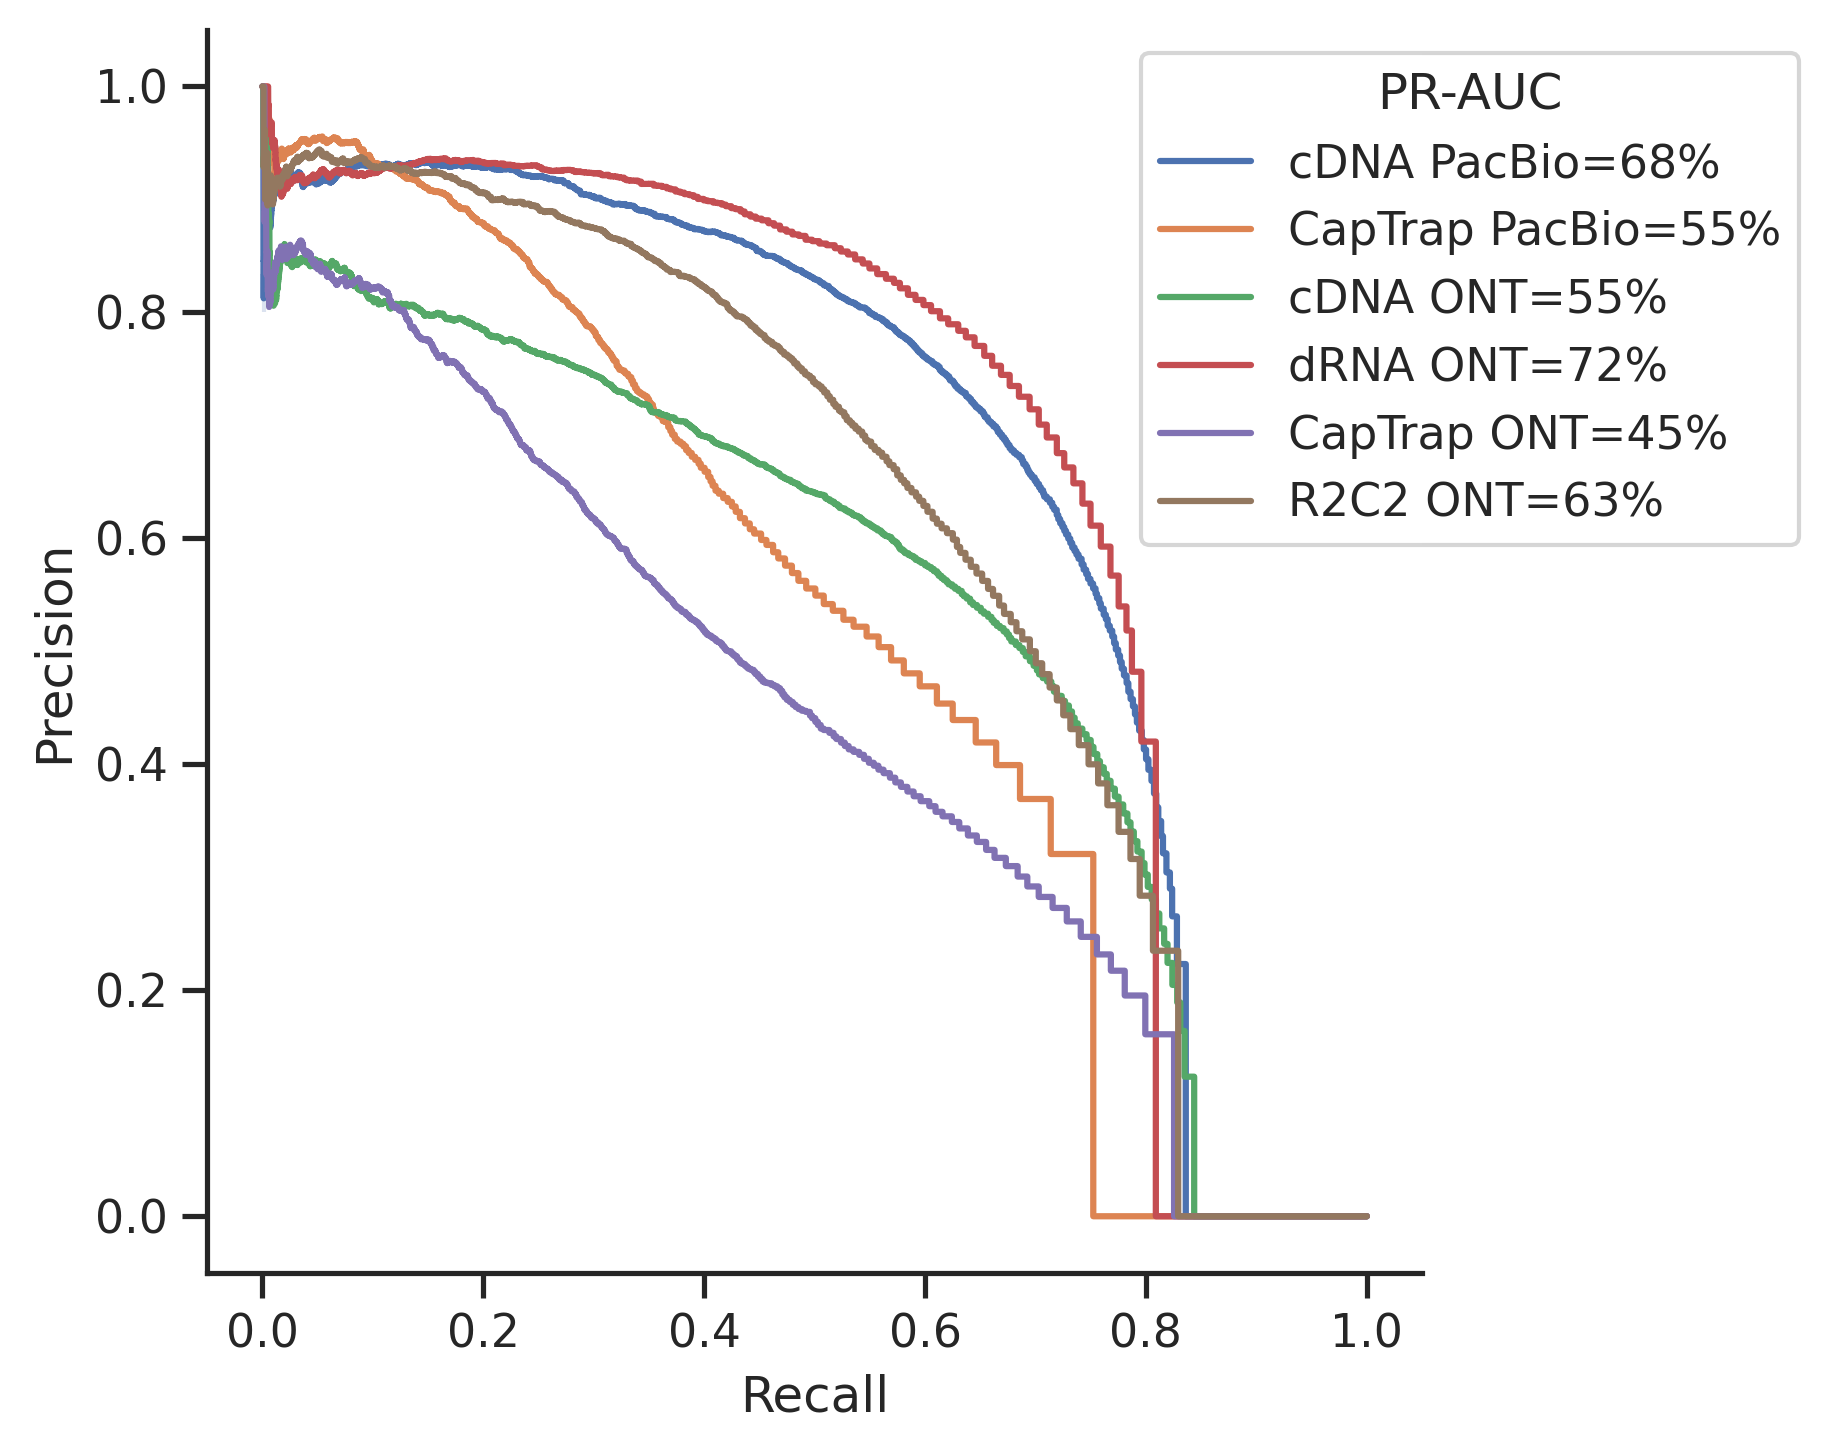

In [8]:
plt.figure(figsize=(5, 5), dpi=300)

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

df_benchmark = list()

for label, df in results_benchmark.items():    
    ground_truth = list((df['polyA_site'] != -1).astype(int))
    score = df[f'tpm_{label}'].replace(-1, 0)

    prec, recall, threshold = precision_recall_curve(
        ground_truth, score, pos_label=1)
    prec[0] = 0

    df_benchmark.append(pd.DataFrame({
        'data source': f'{label}={int(auc(recall, prec) * 100)}%',
        'Precision': prec,
        'Recall': recall
    }))
    
df_benchmark = pd.concat(df_benchmark).reset_index(drop=True)
    
sns.lineplot(data=df_benchmark, y='Precision', x='Recall', 
             hue='data source', 
             drawstyle='steps-pre')

plt.legend()._legend_box.align='right'

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.legend(bbox_to_anchor=(0.75, 1.), loc='upper left', title='PR-AUC')

plt.savefig(snakemake.output['pr_curve_plot'], bbox_inches = "tight")

In [11]:
from collections import defaultdict

df_overlap = pd.DataFrame({})

paths = [
    snakemake.input['quantseq'][0],
    *snakemake.input['lapa_dir']
]

for i in tqdm(paths):
    
    result_i = LapaResult(i, tpm_cutoff=0)
    gr_i =  pr.PyRanges(result_i.read_cluster(), int64=True)
    gr_i = gr_i[gr_i.tpm > 5]
    gr_i = gr_i[gr_i.signal != 'None@None']
    
    library_prep, platform, _ = Path(i).name.split('_')
    name_i = f'{library_prep} {platform}'.replace('quantseq Illumina', 'Quantseq3')

    for j in paths:
        result_j = LapaResult(j, tpm_cutoff=0)
        gr_j =  pr.PyRanges(result_j.read_cluster(), int64=True)

        gr_j = gr_j[gr_j.signal != 'None@None']

        library_prep, platform, _ = Path(j).name.split('_')
        name_j = f'{library_prep} {platform}'.replace('quantseq Illumina', 'Quantseq3')

        df = gr_i.nearest(gr_j, strandedness='same', suffix=f'_{j}').df
        
        df = df[df['Distance'] < 1]

        df_overlap.loc[name_i, name_j] = df.shape[0] / gr_i.df.shape[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:52<00:00, 16.08s/it]


Text(86.24999999999996, 0.5, 'Target')

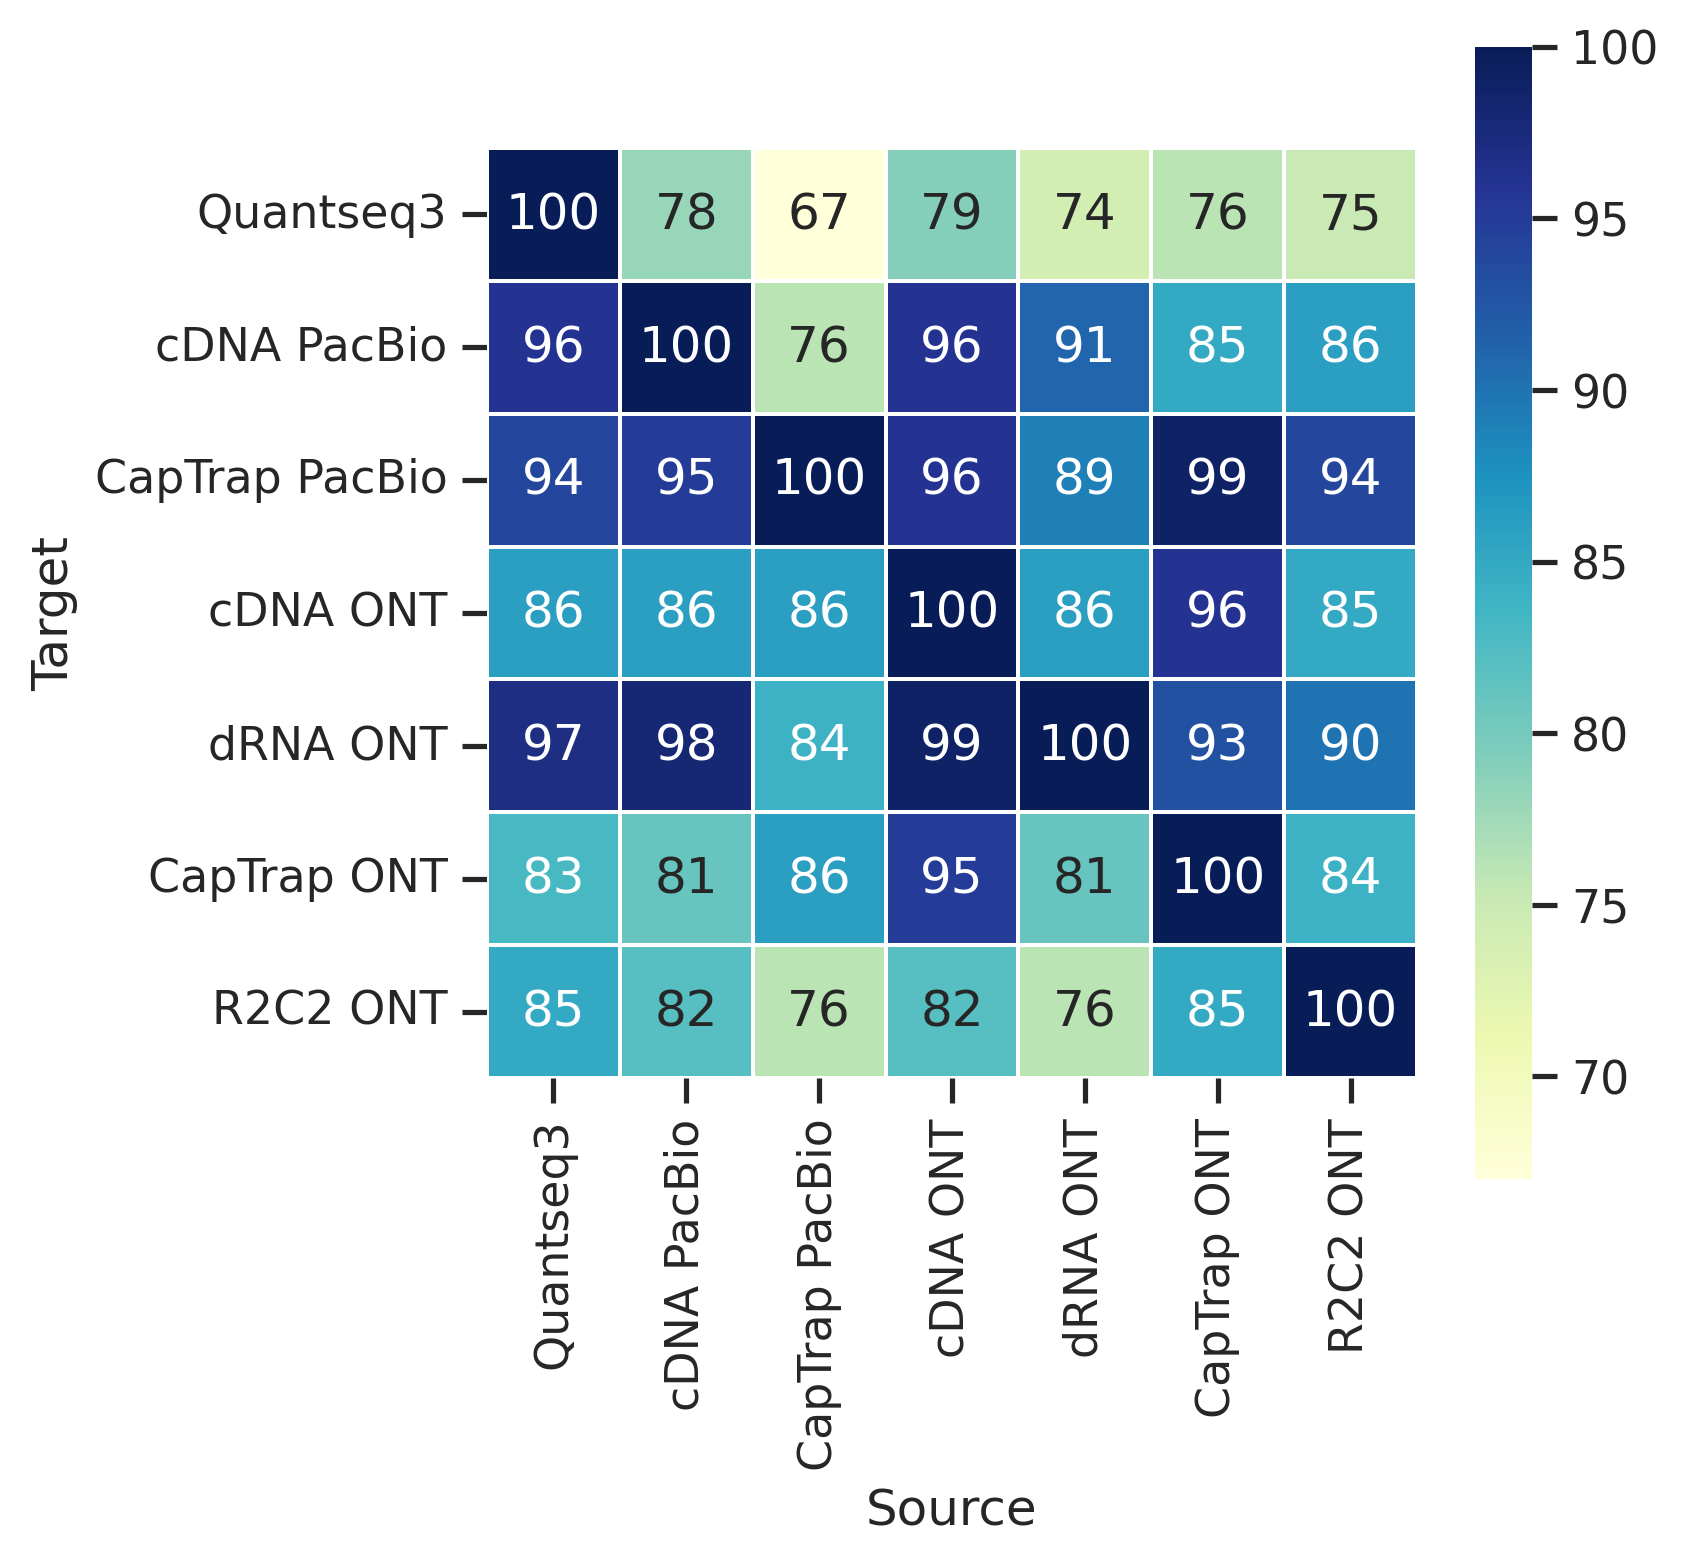

In [12]:
plt.figure(dpi=300, figsize=(5, 5))

sns.heatmap((df_overlap * 100).astype(int), annot=True, square=True,
            fmt="d", linewidths=.5, cmap="YlGnBu")
plt.xlabel('Source')
plt.ylabel('Target')
plt.savefig(snakemake.output['heatmap'], bbox_inches = "tight")